VEHICLE NUMBER PLATE DETECTION

Importing the Required Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


Checking the Version of Tensor Flow library

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extracting Bounding Boxes from XML file for each image

In [ ]:
path = glob('..\content\drive\MyDrive\archive(3)\*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

converting the Bounding boxes into Data frames

In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('/content/drive/MyDrive/labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../input/number-plate-detection/images/N148.xml,244,369,240,293
1,../input/number-plate-detection/images/N177.xml,331,538,263,317
2,../input/number-plate-detection/images/N173.xml,80,335,150,243
3,../input/number-plate-detection/images/N213.xml,131,209,129,153
4,../input/number-plate-detection/images/N119.xml,180,559,216,314


In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/drive/MyDrive/archive (3)/cars_test/cars_test',filename_image)
    return filepath_image
getFilename(filename)

'../input/number-plate-detection/images/N148.jpeg'

In [ ]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['../input/number-plate-detection/images/N148.jpeg',
 '../input/number-plate-detection/images/N177.jpeg',
 '../input/number-plate-detection/images/N173.jpeg',
 '../input/number-plate-detection/images/N213.jpeg',
 '../input/number-plate-detection/images/N119.jpeg',
 '../input/number-plate-detection/images/N103.jpeg',
 '../input/number-plate-detection/images/N166.jpeg',
 '../input/number-plate-detection/images/N127.jpeg',
 '../input/number-plate-detection/images/N162.jpeg',
 '../input/number-plate-detection/images/N198.jpeg']

READING THE DATA
This is a very important step, in this process we will take each and every image and convert it into an array using OpenCV and resize the image into 224 x 224 which is the standard compatible size of the pre-trained transfer learning model.

In [ ]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

Following that, we will simply divide the image by the maximum number to normalize it because we are aware that the maximum number for an 8-bit image is 28 -1 = 255. We shall split our image 255.0 because of this. Normalization (Min-Max Scaler) is the process of analyzing an array to find its maximum value. Additionally, we must standardize our labels. Since the deep learning model's output range ought to fall between 0 and 1. The diagonal points must be divided by the image's width and height in order to normalize the labels. and finally, a Python list of values.

SPLITTING THE DATASET

In [ ]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

Now split the data into training and testing set using Sklearn

In [ ]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

DEEPLEARNING FOR DETECTING THE OBJECTS

An image collection called ImageNet is used to train a convolutional neural network called Inception-ResNet-v2. With 164 layers, the network can identify 1000 different object types from photos, including several animals and keyboards, mice, and pencils. The network has so acquired rich feature representations for a variety of images. For the classification job, the Inception-ResNet-v2 was employed. In Figure 9, the network architecture is displayed. Based on a combination of the Residual connection and the Inception framework, Inception-Resnet-v2 is developed. Residual connections are utilized in the Inception-Resnet block to integrate multiple sized convolutional filters. In addition to avoiding the degradation issue brought on by deep structures, the introduction of reyfual connections speeds up training.


Now We are ready to train a deep learning model for object detection. Here we will use the Inception-ResNet-v2 model with pre-trained weights and train this to our data. We are already import necessary libraries from TensorFlow previously, lets continue.

In [ ]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219070464/219055592 [==============================] - 1s 0us/step


Now compile the model and  have a look at our summary. Don't surprise summary will be a bit massive. The summary is textual and includes information about: The layers and their order in the model. The output shape of each layer. The number of parameters (weights) in each layer.

In [ ]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

 Training the INCEPTION-RESNET-V2

In [ ]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=140,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/140
18/18 [==============================] - 33s 539ms/step - loss: 0.0464 - val_loss: 0.0386
Epoch 2/140
18/18 [==============================] - 3s 178ms/step - loss: 0.0166 - val_loss: 0.0212
Epoch 3/140
18/18 [==============================] - 3s 183ms/step - loss: 0.0084 - val_loss: 0.0172
Epoch 4/140
18/18 [==============================] - 3s 179ms/step - loss: 0.0059 - val_loss: 0.0144
Epoch 5/140
18/18 [==============================] - 3s 178ms/step - loss: 0.0047 - val_loss: 0.0118
Epoch 6/140
18/18 [==============================] - 4s 203ms/step - loss: 0.0038 - val_loss: 0.0095
Epoch 7/140
18/18 [==============================] - 3s 181ms/step - loss: 0.0031 - val_loss: 0.0122
Epoch 8/140
18/18 [==============================] - 3s 178ms/step - loss: 0.0028 - val_loss: 0.0111
Epoch 9/140
18/18 [==============================] - 3s 178ms/step - loss: 0.0026 - val_loss: 0.0107
Epoch 10/140
18/18 [==============================] - 3s 182ms/step - loss: 0.0022 - val_l

In [ ]:
model.save('./object_detection.h5')

In [ ]:
# Load model
model = tf.keras.models.load_model('./object_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


Next is loading our TEST picture with right path to it. I loaded some more images for this purpose  only - folder TEST

In [ ]:
path = '/content/drive/MyDrive/archive (3)/cars_test/cars_test.jpeg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)


Height of the image = 729
Width of the image = 901


Now we can have a look at our image *Figure 13*

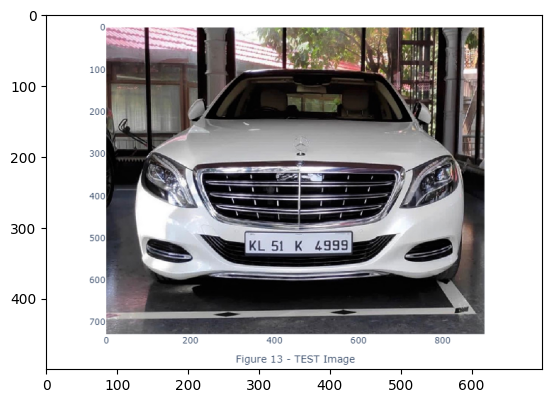

In [ ]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')



So, let's look into the shape of my image.

In [ ]:
image_arr_224.shape

(224, 224, 3)

But in order to pass this image of a model, we need to provide the data in the dynamic fourth dimension. And what one indicates is a number of images. So here we are just passing only one image.

In [ ]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

DE-NORMALIZE THE OUTPUT

In [ ]:
# Make predictions
coords = model.predict(test_arr)
coords

array([[0.36922443, 0.6385739 , 0.65141064, 0.73284334]], dtype=float32)

We have got the output from the model and output what we got is the normalized output. So, what we need to do is to convert back into our original form values, which actually we did in during the training process, in the training process, we have the original form values and convert that normalized one. So basically, we will de-normalize the values back.

In [ ]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[332.67121065, 575.35507035, 474.87835604, 534.24279445]])

 BOUNDING BOX

Now we will draw bounding box on top of the image. I just want to provide the two diagonal points. Let's make use of these points and let's draw the rectangle box.

In [ ]:
coords = coords.astype(np.int32)
coords

array([[332, 575, 474, 534]], dtype=int32)

In [ ]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(332, 474) (575, 534)


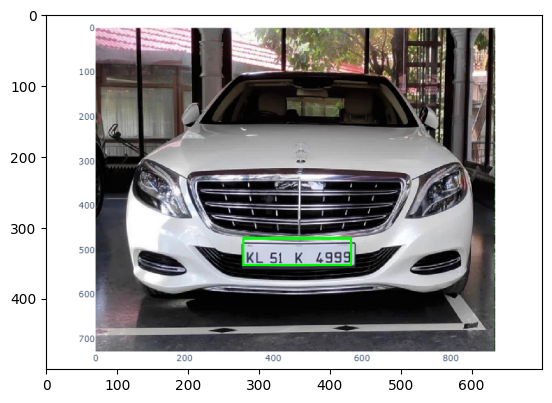

In [ ]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))




 CREATING THE PIPELINE

Now what we'll do, let's put it all together in one place and create function. And in the end visualize it. Our output will return image and coordinates of bounding box.

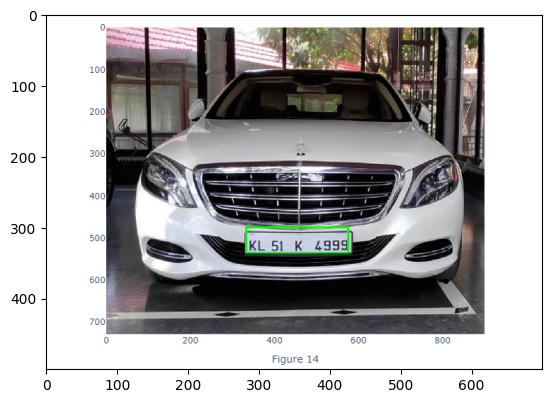

In [ ]:
# Create pipeline
path = '/content/drive/MyDrive/archive (3)/cars_test/cars_test.jpeg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')


OPTICAL CHARACTER RECOGNITION

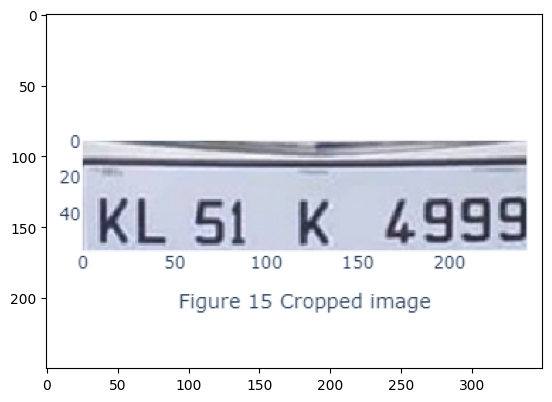

In [ ]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')


With use of tesseract, we will extract the text from the mage.


In [ ]:
# extract text from image
text = pt.image_to_string(roi)
print(text)

 

KL 51 K 4999



YOLO

In [ ]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/content/drive/MyDrive/archive (3)/cars_train/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)

    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height
0,../input/number-plate-detection/images/N148.xml,244,369,240,293,../input/number-plate-detection/images/N148.jpeg,600,430
1,../input/number-plate-detection/images/N177.xml,331,538,263,317,../input/number-plate-detection/images/N177.jpeg,850,681
2,../input/number-plate-detection/images/N173.xml,80,335,150,243,../input/number-plate-detection/images/N173.jpeg,445,349
3,../input/number-plate-detection/images/N213.xml,131,209,129,153,../input/number-plate-detection/images/N213.jpeg,350,196
4,../input/number-plate-detection/images/N119.xml,180,559,216,314,../input/number-plate-detection/images/N119.jpeg,678,475


Now the next step is let me calculate the center_x, center_y, width and height, which is normalized to width and height. And as well normalize width and height of bounding box.

In [ ]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,../input/number-plate-detection/images/N148.xml,244,369,240,293,../input/number-plate-detection/images/N148.jpeg,600,430,0.510833,0.619767,0.208333,0.123256
1,../input/number-plate-detection/images/N177.xml,331,538,263,317,../input/number-plate-detection/images/N177.jpeg,850,681,0.511176,0.425844,0.243529,0.079295
2,../input/number-plate-detection/images/N173.xml,80,335,150,243,../input/number-plate-detection/images/N173.jpeg,445,349,0.466292,0.563037,0.573034,0.266476
3,../input/number-plate-detection/images/N213.xml,131,209,129,153,../input/number-plate-detection/images/N213.jpeg,350,196,0.485714,0.719388,0.222857,0.122449
4,../input/number-plate-detection/images/N119.xml,180,559,216,314,../input/number-plate-detection/images/N119.jpeg,678,475,0.544985,0.557895,0.558997,0.206316


DOWNLOADING THE PRETRAINED YOLO MODEL from GIT

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15647, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 15647 (delta 128), reused 170 (delta 96), pack-reused 15393
Receiving objects: 100% (15647/15647), 14.65 MiB | 28.41 MiB/s, done.
Resolving deltas: 100% (10656/10656), done.


In [ ]:
!pip install -r ./yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
  Attempting uninstall: gitpython
    Found existing installation: GitPython 3.1.27
    Uninstalling GitPython-3.1.27:
      Successfully uninstalled GitPython-3.1.27
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
thinc 8.0.16 requires typing-extensions<4.0.0.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.2.0 which is incompatible.
spacy 3.2.4 requires typing-ex

In [ ]:
### split the data into train and test
df_train = df.iloc[:200]
df_test = df.iloc[200:]

We will copy each image into the folder train and test and generate .txt which has label info.

In [ ]:
train_folder = '/content/drive/MyDrive/archive (3)/cars_train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')

    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

test_folder = '/content/drive/MyDrive/archive (3)/cars_test/cars_test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')

    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

TRAINING YOLO Model

Next step is basically train model. It could take time be ready for it. You can use Kaggle or GoogleColab for it. We already set out data.yaml file, lets us give path to it and train model. Below you will find code to cleare you GPU(It helped me a lot and will save you time.)

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=3810ee15c8e528e0a350ae589864a11358e113deb9ad96fe7f84632d68d90d63
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 98% |
GPU Usage after emptying the cache
| ID | GPU  | MEM |
-------------------
|  0 | 100% |  2% |


In [ ]:
!python ./yolov5/train.py --data ../input/number-plate-detection/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=../input/number-plate-detection/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval

When model trained, we need to save our it in order to use it at OCR in onnx format as below:

In [ ]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx --opset 12

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-163-g016e046 Python-3.7.12 torch-1.11.0 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 1.11.0...
TorchScript: export success ✅ 2.3s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)
requirements: YOLOv5 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages that are ins

In [ ]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

Let me first load TEST image, it will have a plate number on it.

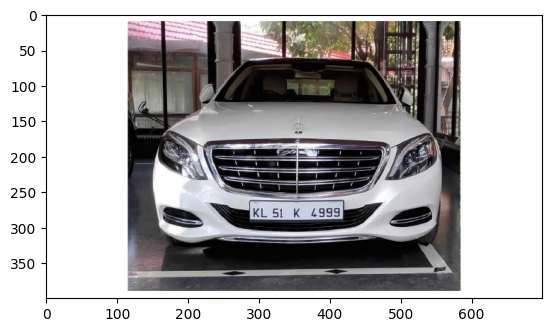

In [ ]:
# LOAD THE IMAGE
img = io.imread('/content/drive/MyDrive/archive (3)/cars_test/cars_test.jpeg')

fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()


Now, we will load our YOLO model.

In [ ]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

I must now parse this image using my YOLO model in order to obtain the prediction. Important: We must set the size to 640 for the input width and 640 for the input height.

There are six columns and 25,200 rows.  You may find information about the bounding box, which is center X, center Y, center W, and center H, in the first four columns. Also, 640 by 640 is used to standardize these data. The probability and confidence are the following two values. Since we only have one class—number plate—confidence indicates our level of confidence in recognizing the bounding box. The probability score of the class comes next.

Let's enumerate the boxes.Based on the likelihood and confidence scores, we must filter detections. Allow me to filter from class >0.25 using the confidence >0.4.

One of the main problems with YOLO modeling is that it will offer you several boxes for the same object, but it will also give you repeating boxes. We must execute the non-maximum suppression in order to do it. We must supply all of our clean boxes and confidences in order to complete it.

I'll use bounding boxes at the conclusion of that section of code to draw the rectangular box onto our image. and will put everything into functions.

In [ ]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]

    return input_image, detections

def non_maximum_supression(input_image,detections):

    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE

    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()

    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)

    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [ ]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

Here we will not only detect license plate but else extract test from it. We already done it before let’s repeat it again. We will write function. First from bounding box we need to take our x,y,w,h and extract ROI. I place it at top of our functions in drawing part.

In [ ]:
# extrating text
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]

    if 0 in roi.shape:
        return 'no number'

    else:
        text = pt.image_to_string(roi)
        text = text.strip()

        return text

In [ ]:
# test
img = io.imread('/content/drive/MyDrive/archive (3)/cars_test/cars_test.jpeg')
results = yolo_predictions(img,net)

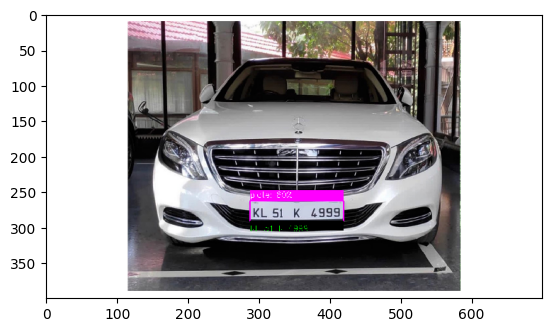

In [ ]:
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()


Vehicle tracking has grown in importance as a study topic due to the rise in automobiles, which helps with effective traffic management, surveillance, and the recovery of stolen vehicles. Efficient real-time license plate detection and recognition are crucial for this reason. License plate recognition is a major difficulty in developing countries because of variations in backdrop and text color, font style, license plate size, and non-standard characters. This work uses a deep learning approach to increase the effectiveness of license plate identification in order to get around such problems. The gathered photos have been taken at several angles of rotation, at different distances from the camera, and with different lighting and contrast settings. They have also been verified to yield a high identification rate. Law enforcement authorities and private entities can utilize this strategy to